# Computing CrowdTruth metrics for SUMO ticket annotations

This notebook computes CrowdTruth metrics for our SUMO ticket annotations. 

It is based on `Free Input Task - Person Annotation in Video.ipynb` from the CrowdTruth repo. 
<br><br><br>
**Input**: Ticket annotation JSON containing only annotated tickets

**Output**: CrowdTruth quality metrics for workers (taggers), tickets, and tags
<br><br><br>
Make sure you install from `requirements.txt` before running this notebook

`pip install -r requirements.txt`

In [1]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wfenton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wfenton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wfenton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/wfenton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing

Take a JSON file containing annotated tickets, convert it to a CSV so that we can import it using pandas

In [2]:
from pathlib import Path

# this adds the CANOSP root to the path, so we can import from there
import sys
sys.path.append('../')

from json_to_crowdtruth_csv import ticket_to_csv

# root of the repository
canosp_root_path = Path("./..")

# tickets.csv is the 200MB ticket JSON from Google Drive
input_json_path = canosp_root_path / "data/mturk_tickets.json"
output_csv_path = canosp_root_path / "data/crowdtruth_tickets.csv"

ticket_to_csv(input_json_path, output_csv_path)

Taggers: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Finished writing annotations to ../data/crowdtruth_tickets.csv
318601 tickets (0 duplicates)
7302 annotations (0 duplicates)


Load the CSV into a pandas dataframe and display the format

In [3]:
import pandas as pd

input_data = pd.read_csv(output_csv_path)
input_data.head()

,_unit_id,_created_at,_id,_started_at,_worker_id,keywords
0,955006,1/1/2020 00:02:00,0,1/1/2020 00:00:00,9,"[""spam""]"
1,955006,1/1/2020 00:02:00,1,1/1/2020 00:00:00,A6XRUXBQW762S,"[""ticket"",""blank"",""this"",""is""]"
2,955006,1/1/2020 00:02:00,2,1/1/2020 00:00:00,A3MAQONJ6XFBRD,"[""problem"",""arrow"",""firefox""]"
3,955006,1/1/2020 00:02:00,3,1/1/2020 00:00:00,A17FYT6ZH5L6RL,"[""ticketfailure"",""error"",""usermistake"",""badkey..."
4,1066283,1/1/2020 00:02:00,4,1/1/2020 00:00:00,1,"[""deleted""]"


CrowdTruth config

In [4]:
class CanospConfig(DefaultConfig):
    inputColumns = []
    outputColumns = ["keywords"]
    customPlatformColumns = []
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = []
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[]','no tags'))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))

        return judgments


Load the data

In [5]:
data, config = crowdtruth.load(
    file = str(output_csv_path),
    config = CanospConfig()
)

data['judgments'].head()

,output.keywords,output.keywords.count,output.keywords.unique,unit,worker,started,submitted,duration,job
judgment,,,,,,,,,
0,{'spam': 1},1,1,955006,9,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
1,"{'ticket': 1, 'blank': 1, 'this': 1, 'is': 1}",4,4,955006,A6XRUXBQW762S,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
2,"{'problem': 1, 'arrow': 1, 'firefox': 1}",3,3,955006,A3MAQONJ6XFBRD,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
3,"{'ticketfailure': 1, 'error': 1, 'usermistake'...",4,4,955006,A17FYT6ZH5L6RL,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
4,{'deleted': 1},1,1,1066283,1,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets


## Compute CrowdTruth metrics

In [6]:
results = crowdtruth.run(data, config)

results.keys()

dict_keys(['jobs', 'units', 'workers', 'judgments', 'annotations'])

In [7]:
taggers = {
    0 : "SUMO",
    1 : "Martin",
    2 : "Yuan",
    3 : "Will",
    4 : "Ana",
    5 : "Michael",
    6 : "Eve",
    7 : "Brady",
    8 : "Joni",
    9 : "Roland"
}

# Results

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# set plot size
plt.rcParams['figure.figsize'] = [8, 5]

## Ticket and Tag Quality

### Tag quality scores

**worker**: tagger ID

**unit**: number of tickets annotated by the tagger

**uqs**: unit quality score (0-1) - expresses the overall worker agreement over one ticket

In [9]:
unit_results = results["units"]

unit_results.rename(columns={'output.keywords': 'tags', 'unit_annotation_score': 'tag_quality'}, inplace=True)

unit_results[["uqs", "tags", "tag_quality"]].sort_values("uqs", ascending=False)

,uqs,tags,tag_quality
unit,,,
1246135,1.000000,"{'display': 2, 'startup': 2, 'sites': 2, 'page...","{'display': 1.0, 'startup': 1.0, 'sites': 1.0,..."
1233971,1.000000,"{'toolbar': 2, 'customize': 2, 'bookmark': 2, ...","{'toolbar': 1.0, 'customize': 1.0, 'bookmark':..."
1242621,0.912871,"{'quantum': 2, 'extension': 2, 'shareongab': 2...","{'quantum': 1.0, 'extension': 1.0, 'shareongab..."
1246057,0.912871,"{'site': 2, 'ssl': 2, 'wrong': 2, 'name': 2, '...","{'site': 1.0, 'ssl': 1.0, 'wrong': 1.0, 'name'..."
1234370,0.912871,"{'set': 2, 'up': 2, 'firefox': 1, 'delivery': ...","{'set': 1.0, 'up': 1.0, 'firefox': 0.531088794..."
...,...,...,...
1247538,0.000000,"{'sec': 1, 'firefox': 1, 'revoked': 1, 'nellig...","{'sec': 0.46566472351306376, 'firefox': 0.4656..."
1246451,0.000000,"{'ad': 1, 'blocker': 1, 'issues': 1, 'visit.':...","{'ad': 0.025926761676702353, 'blocker': 0.0259..."
1245536,0.000000,"{'sec': 1, 'firefox': 1, 'bad': 1, 'signature'...","{'sec': 0.549051236926153, 'firefox': 0.549051..."


In [10]:
tags = {}

for index, row in unit_results.iterrows():
    for tag in row["tags"].keys():
        if tag not in tags.keys():
            tags[tag] = {
                "tag": tag,
                "count": row["tags"][tag],
                "scores": [row["tag_quality"][tag]]
            }
        else:
            tags[tag]["count"] += row["tags"][tag]
            tags[tag]["scores"].append(row["tag_quality"][tag])
            
for tag in tags:
    tags[tag]["average_score"] = sum(tags[tag]["scores"]) / len(tags[tag]["scores"])
    
tags = list(tags.values())
    
tags_df = pd.DataFrame(tags)

tags_df.rename(columns={"count": "n"}, inplace=True)

Text(0, 0.5, 'Count')

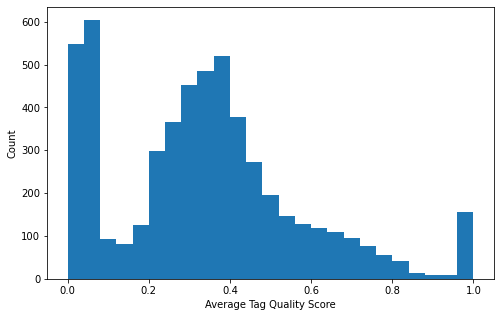

In [11]:
plt.hist(tags_df["average_score"], bins=25)
plt.xlabel("Average Tag Quality Score")
plt.ylabel("Count")

In [12]:
candidate_tags = tags_df

# only select tags used >= X times
count_threshold = 8
candidate_tags = candidate_tags[candidate_tags.n > count_threshold]

# select a maximum of X tags (highest average scores selected)
num_tags = 1000
candidate_tags = candidate_tags.nlargest(num_tags, columns=["average_score"])

# select tags with average_score >= X
score_threshold = 0.35
candidate_tags = candidate_tags[candidate_tags.average_score > score_threshold]

# number of rows to display
max_rows = num_tags
pd.set_option("display.max_rows", max_rows)

df_csv_path = canosp_root_path / "data/candidate_tags.csv"
candidate_tags.to_csv(df_csv_path)

# display candidate tags
print(len(candidate_tags), "tags")
candidate_tags[["tag", "n", "average_score"]].sort_values("average_score", ascending=False)

516 tags


,tag,n,average_score
937,bing,24,0.971334
4739,widget,9,0.916279
808,instagram,15,0.871685
536,pinterest,13,0.868867
469,console,9,0.857968
479,pdf,70,0.848687
866,paypal,17,0.830282
3238,wikipedia,14,0.823243
722,portal,14,0.803553
38,cpu,28,0.801751


Text(0, 0.5, 'Count')

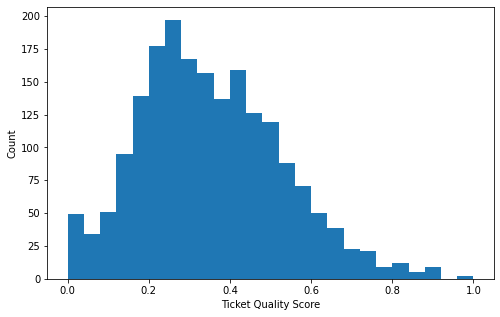

In [13]:
plt.hist(unit_results["uqs"], bins=25)
plt.xlabel("Ticket Quality Score")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

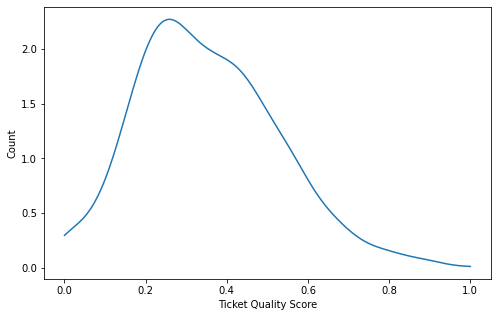

In [14]:
import numpy as np
from scipy.stats import gaussian_kde

density = gaussian_kde(unit_results["uqs"])
xs = np.linspace(0,1,200)
density.covariance_factor = lambda : .25
density._compute_covariance()

plt.plot(xs, density(xs))
plt.xlabel("Ticket Quality Score")
plt.ylabel("Count")

## Tagger Quality

### Tagger quality scores

**worker**: tagger ID

**unit**: number of tickets annotated by the tagger

**wqs**: worker quality score (0-1) - measures the overall agreement of one tagger with the other taggers. function of `wwa` and `wsa`

**wwa**: worker-worker agreement (0-1) - measures the average pairwise agreement between a tagger and all other taggers, indicating how close a tagger performs compared to taggers solving the same task

**wsa**: worker-sentence agreement (0-1) - the agreement of a tagger with all the taggers that annotated the same ticket

In [15]:
worker_results = results["workers"]
worker_results["name"] = worker_results.index.to_series().map(taggers)

# average number of unique tags per annotation, per worker
num_tags_results = results["judgments"][["worker", "output.keywords.unique"]]
average_num_tags = num_tags_results.groupby(['worker'], as_index=True).mean()

worker_results = worker_results.join(average_num_tags)

worker_results.rename(columns={'output.keywords.unique': 'average_unique_tags', 'unit': 'tickets'}, inplace=True)

# wqs sorted by wqs, descending order 
worker_results.sort_values("wqs", ascending=False)[["name", "tickets", "average_unique_tags", "wqs", "wwa", "wsa"]]

,name,tickets,average_unique_tags,wqs,wwa,wsa
worker,,,,,,
A1UX21H617D31V,NaN,1,4.000000,7.675703e-01,8.390553e-01,9.148029e-01
A271V19C06841K,NaN,1,4.000000,6.677023e-01,7.858488e-01,8.496574e-01
A6QFAYKNRSO75,NaN,2,5.000000,6.494110e-01,7.739888e-01,8.390445e-01
A2YF7T7OCRQVP7,NaN,2,4.000000,5.388258e-01,6.783905e-01,7.942708e-01
AB77P0ABU54TS,NaN,2,9.500000,4.954195e-01,6.579424e-01,7.529831e-01
AVCWRWV80TGC7,NaN,1,5.000000,4.831107e-01,6.549190e-01,7.376649e-01
AHBEBTY41ZW52,NaN,1,4.000000,4.500000e-01,6.708204e-01,6.708204e-01
AN708FWWYGN1E,NaN,4,5.500000,4.382901e-01,6.545514e-01,6.696038e-01
A1GHBMK32MNCV3,NaN,1,5.000000,4.177513e-01,6.386285e-01,6.541382e-01


In [16]:
pd.set_option('display.max_rows', 100)
worker_results[worker_results.tickets > 10].sort_values("wqs", ascending=False)[["name", "tickets", "average_unique_tags", "wqs", "wwa", "wsa"]]

,name,tickets,average_unique_tags,wqs,wwa,wsa
worker,,,,,,
A1RB2RPK7JZSDV,NaN,19,8.789474,0.357276,0.565480,0.631810
AJKA9BKC011F2,NaN,34,7.352941,0.349869,0.558906,0.625989
A6XRUXBQW762S,NaN,190,5.500000,0.344060,0.553705,0.621378
A32NFF6EM31R8P,NaN,36,6.083333,0.311504,0.505947,0.615685
A2V5XDYKKJVE4C,NaN,409,4.850856,0.303779,0.519357,0.584914
A1CB72B51L7TKE,NaN,17,6.294118,0.301711,0.518385,0.582021
A3LZ8S328U13AI,NaN,21,4.904762,0.300800,0.500921,0.600494
A351BKQC7NEH3A,NaN,43,11.186047,0.290933,0.504593,0.576571
A3P7M9666KJCP,NaN,30,4.900000,0.285163,0.487228,0.585277


Histogram of tagger quality scores

Text(0, 0.5, 'Count')

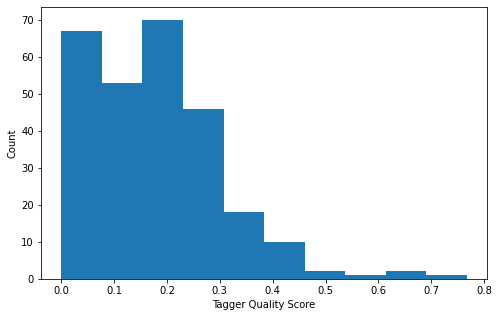

In [17]:
plt.hist(worker_results["wqs"])
plt.xlabel("Tagger Quality Score")
plt.ylabel("Count")

Plot tagger quality metrics based on number of tags per ticket

With such a low sample size I don't know how much this actually tells us, but it's kinda interesting

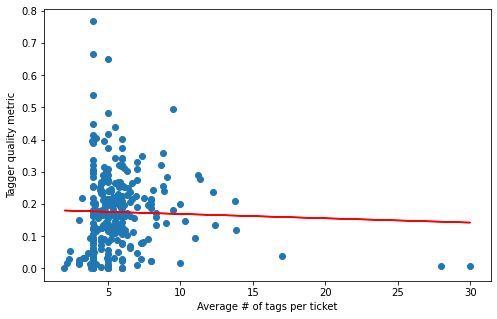

In [18]:
import numpy as np

x = worker_results["average_unique_tags"]
y = worker_results["wqs"]

plt.scatter(x, y)
plt.xlabel("Average # of tags per ticket")
plt.ylabel("Tagger quality metric")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r")